<a href="https://colab.research.google.com/github/Sahil0707/Arrythmia-Detection/blob/main/Detecting_Heart_Arrhythmias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -r -N -c -np https://data.4tu.nl/file/48acba04-96bc-4131-b52f-9e18458ad92b/f4bbc47a-f7d8-4e17-a6cc-5c49cde2934b

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2024-11-04 14:15:55 (2.25 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2024-11-04 14:15:55--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   567KB/s    in 3.4s    

2024-11-04 14:15:58 (567 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2024-11-04 14:15:58--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

In [ ]:
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']


In [ ]:
!pip install wfdb
import wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Define the data path as a string
data_path = "/content/physionet.org/files/mitdb/1.0.0"
pts = ["100", "101", "102"]  # Example patient IDs

df = pd.DataFrame()

for pt in pts:
    # Construct the file path without the extension for wfdb.rdann
    file = os.path.join(data_path, pt)

    # Check if the file exists to avoid FileNotFoundError
    if os.path.exists(file + '.atr'):  # Checking for the '.atr' file specifically
        annotation = wfdb.rdann(file, 'atr')
        sym = annotation.symbol
        values, counts = np.unique(sym, return_counts=True)
        df_sub = pd.DataFrame({'sym': values, 'val': counts, 'pt': [pt] * len(counts)})
        df = pd.concat([df, df_sub], axis=0)
    else:
        print(f"File not found: {file}.atr")

# Display the DataFrame
print(df)

  sym   val   pt
0   +     1  100
1   A    33  100
2   N  2239  100
3   V     1  100
0   +     1  101
1   A     3  101
2   N  1860  101
3   Q     2  101
4   |     4  101
5   ~     4  101
0   +     5  102
1   /  2028  102
2   N    99  102
3   V     4  102
4   f    56  102


In [ ]:
df.groupby('sym').val.sum().sort_values(ascending = False)

,val
sym,
N,4198
/,2028
f,56
A,36
+,7
V,5
|,4
~,4
Q,2


In [ ]:
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [ ]:
# break into normal, abnormal or nonbeat
df['cat'] = -1

df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1


In [ ]:
df.groupby('cat').val.sum()

,val
cat,
-1,17
0,4198
1,2125


In [ ]:
def load_ecg(file):

 # load the ecg
 record = wfdb.rdrecord(file)

 # load the annotation
 annotation = wfdb.rdann(file, 'atr')

 # extract the signal
 p_signal = record.p_signal

 # verify frequency is 360
 assert record.fs == 360, 'sample freq is not 360'



 # extract symbols and annotation index
 atr_sym = annotation.symbol
 atr_sample = annotation.sample

 return p_signal, atr_sym, atr_sample

In [ ]:
# Define data path and patient ID
data_path = "/content/physionet.org/files/mitdb/1.0.0/"
file = data_path + pts[0]

# Load the ECG signal and annotation
record = wfdb.rdrecord(file)  # Load the ECG signal
annotation = wfdb.rdann(file, 'atr')  # Load the annotation

# Extract p_signal (ECG signal) and annotation details
p_signal = record.p_signal
atr_sym = annotation.symbol  # Symbols for annotations
atr_sample = annotation.sample  # Annotation locations in the signal

# Count unique annotation symbols and their occurrences
values, counts = np.unique(atr_sym, return_counts=True)
for v, c in zip(values, counts):
    print(v, c)

+ 1
A 33
N 2239
V 1


In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [ ]:
x = np.arange(len(p_signal))

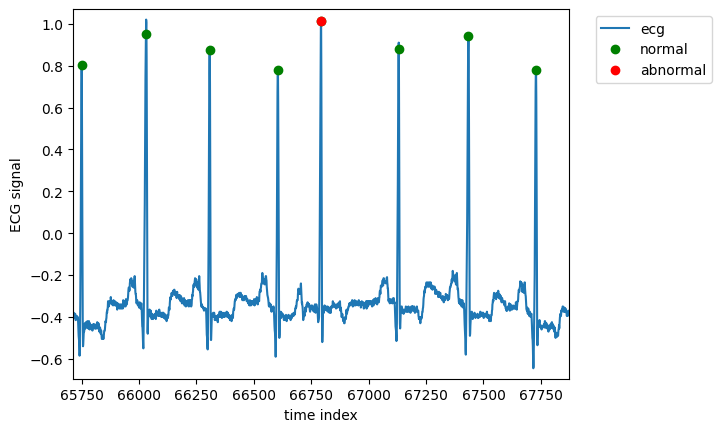

In [ ]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal' )

plt.xlim(left, right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')

plt.ylabel('ECG signal')

plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')

plt.show()


In [ ]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output:
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in pts:
        file = data_path + pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]

        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'
    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y

    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []

    # keep track of rows
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [ ]:
num_sec = 3
fs = 360
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [ ]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()

model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))

model.add(Dropout (rate = 0.25))

model.add(Dense(1, activation = 'sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile the model ~ use categorical crossentropy, and the adam optimizer
model.compile(
         loss = 'binary_crossentropy',
         optimizer = 'adam',
         metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9155 - loss: 0.2310
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9876 - loss: 0.0498
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9909 - loss: 0.0427
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9948 - loss: 0.0210
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9964 - loss: 0.0130


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
# calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print( 'AUC:%.3f'%auc)

    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)

    print('precision:%.3f' %precision)
    print('specificity:%.3f' %specificity)

    print( 'prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')

    return auc, accuracy, recall, precision, specificity

In [ ]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.33886255924170616

In [ ]:
# reshape input to be (samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print (X_train_cnn.shape)
print (X_valid_cnn.shape)

(4220, 2160, 1)
(2079, 2160, 1)


In [ ]:
from keras.layers import Conv1D

model = Sequential()
model.add(Conv1D(filters = 128, kernel_size =5, activation= 'relu', input_shape= (2160, 1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))
# compile the model - use categorical crossentropy, and the adam optimizer
model. compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
132/132 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.9478 - loss: 0.1620
Epoch 2/2
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.9966 - loss: 0.0141


In [ ]:
y_train_preds_cnn=model.predict([X_train_cnn])

predict_classes=np.argmax(y_train_preds_cnn,axis = 1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [ ]:
print('Train');
print_report(y_train,y_train_preds_cnn, thresh);

Train
AUC:1.000
accuracy:1.000
recall:0.999
precision:0.999
specificity:1.000
prevalence:0.339
 


<ipython-input-28-b3548f96ca5f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('specificity:%.3f' %specificity)
<ipython-input-28-b3548f96ca5f>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( 'prevalence:%.3f'%calc_prevalence(y_actual))


In [ ]:
y_valid_preds_cnn =model.predict([X_valid_cnn])

predict_classes=np.argmax(y_valid_preds_cnn,axis = 1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [ ]:
print('Valid');
print_report(y_valid,y_valid_preds_cnn, thresh);

Valid
AUC:1.000
accuracy:0.997
recall:0.996
precision:0.996
specificity:0.998
prevalence:0.330
 


<ipython-input-28-b3548f96ca5f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('specificity:%.3f' %specificity)
<ipython-input-28-b3548f96ca5f>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( 'prevalence:%.3f'%calc_prevalence(y_actual))


In [ ]:
# Set a threshold for abnormal heartbeat detection (e.g., 0.8 for 80% probability)
ABNORMALITY_THRESHOLD = 0.8

def detect_abnormal_heartbeat(probabilities, threshold=ABNORMALITY_THRESHOLD):
    """
    Detects abnormal heartbeats based on the probability scores.

    Parameters:
    - probabilities: A list or numpy array of predicted probability scores from the model.
    - threshold: The probability threshold to classify a heartbeat as abnormal.

    Returns:
    - A list indicating whether each heartbeat is normal (0) or abnormal (1).
    """
    # Classify each heartbeat as abnormal (1) or normal (0) based on the threshold
    abnormalities = [1 if prob >= threshold else 0 for prob in probabilities]
    return abnormalities

# Example: probabilities from the model (dummy data for illustration)
predicted_probabilities = np.array([0.75, 0.82, 0.60, 0.95, 0.40])

# Detect abnormal heartbeats
abnormal_heartbeats = detect_abnormal_heartbeat(predicted_probabilities)
print("Abnormal Heartbeats Detected:", abnormal_heartbeats)

Abnormal Heartbeats Detected: [0, 1, 0, 1, 0]


In [ ]:
def detect_abnormal_heartbeat_with_confidence(probabilities, threshold=ABNORMALITY_THRESHOLD, confidence_interval=0.95):
    """
    Detects abnormal heartbeats based on confidence interval bounds of probability scores.

    Parameters:
    - probabilities: A list or numpy array of predicted probability scores from the model.
    - threshold: The base threshold to classify a heartbeat as abnormal.
    - confidence_interval: Confidence level (e.g., 0.95 for 95%) to adjust the threshold dynamically.

    Returns:
    - A list indicating whether each heartbeat is normal (0) or abnormal (1).
    """
    # Compute the mean and standard deviation of probabilities
    mean_prob = np.mean(probabilities)
    std_prob = np.std(probabilities)

    # Calculate the adjusted threshold using confidence interval
    adjusted_threshold = mean_prob + std_prob * confidence_interval

    # Classify each heartbeat as abnormal (1) or normal (0) based on the adjusted threshold
    abnormalities = [1 if prob >= max(threshold, adjusted_threshold) else 0 for prob in probabilities]
    return abnormalities

# Detect abnormal heartbeats with confidence interval
abnormal_heartbeats_with_confidence = detect_abnormal_heartbeat_with_confidence(predicted_probabilities)
print("Abnormal Heartbeats Detected (with Confidence Interval):", abnormal_heartbeats_with_confidence)

Abnormal Heartbeats Detected (with Confidence Interval): [0, 0, 0, 1, 0]


In [ ]:
# Define thresholds for risk categories
HIGH_RISK_THRESHOLD = 0.85    # High risk if probability ≥ 0.85
MEDIUM_RISK_THRESHOLD = 0.65  # Medium risk if 0.65 ≤ probability < 0.85
LOW_RISK_THRESHOLD = 0.40     # Low risk if 0.40 ≤ probability < 0.65
NO_RISK_THRESHOLD = 0.40      # No risk if probability < 0.40

def classify_arrhythmia_risk(probabilities):
    """
    Classifies the risk level of heart arrhythmia based on predicted probability scores.

    Parameters:
    - probabilities: A list or numpy array of predicted probability scores from the model.

    Returns:
    - A list with classifications: 'High', 'Medium', 'Low', or 'None' for each probability.
    """
    risk_levels = []

    for prob in probabilities:
        if prob >= HIGH_RISK_THRESHOLD:
            risk_levels.append("High")
        elif prob >= MEDIUM_RISK_THRESHOLD:
            risk_levels.append("Medium")
        elif prob >= LOW_RISK_THRESHOLD:
            risk_levels.append("Low")
        else:
            risk_levels.append("None")

    return risk_levels

# Example: probabilities from the model (dummy data for illustration)
predicted_probabilities = np.array([0.90, 0.72, 0.55, 0.30, 0.85])

# Classify arrhythmia risk levels
risk_classifications = classify_arrhythmia_risk(predicted_probabilities)
print("Arrhythmia Risk Classifications:", risk_classifications)

Arrhythmia Risk Classifications: ['High', 'Medium', 'Low', 'None', 'High']


In [ ]:
import pickle

In [ ]:
import pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)


NameError: name 'model' is not defined

In [ ]:
import torch
import torch.nn as nn
import pickle

# Define the model architecture
class ArrhythmiaModel(nn.Module):
    def __init__(self):
        super(ArrhythmiaModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * 112 * 112, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model = ArrhythmiaModel()

# Now you can save the model
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
torch.save(model.state_dict(), 'model.pth')
# or
#torch.save(model, 'model.pth')

In [ ]:
model = ArrhythmiaModel()
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model.eval()

<ipython-input-16-142f747e689d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))


ArrhythmiaModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=401408, out_features=1, bias=True)
    (5): Sigmoid()
  )
)